## Mount Google Drive to access your data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/MyDrive/Ultrasound_project/'

In [ ]:
import random

In [ ]:
#random.seed(13204942)

## Model Definition

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

<figure>
<center>
<img src='https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png' width="500" height="300"/>
<figcaption>Image Caption</figcaption></center>
</figure>

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),  # bias = false because using batchnorm2d
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False),  # bias = false because using batchnorm2d
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv(x)


In [ ]:
class UNET(nn.Module):
  def __init__(self,
               in_channels=3,
               out_channels=1,
               features=[64, 128, 256, 512],
               ):
    super(UNET, self).__init__()
    self.encoders = nn.ModuleList()
    self.decoders = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Encoder part of UNet
    for feature in features:
      self.encoders.append(DoubleConv(in_channels, feature))
      in_channels = feature

    # Decoder part of UNet
    for feature in reversed(features):
      self.decoders.append(
          nn.ConvTranspose2d(
              feature*2, feature, kernel_size=2, stride=2
          )
      )
      self.decoders.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []

    for encoder in self.encoders:
      x = encoder(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.decoders), 2):
      x = self.decoders[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.decoders[idx+1](concat_skip)

    return self.final_conv(x)


In [ ]:
# calculate total parameters of the model
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def test():
  x = torch.randn((1, 1, 540, 540))
  model = UNET(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape

In [ ]:
model = UNET(in_channels=3, out_channels=1)
#print(model)

In [ ]:
para_count = count_parameters(model)
print (f"{para_count:,}")

31,037,633


In [ ]:
para_count = count_parameters(model.decoders)
print (f"{para_count:,}")

12,190,400


In [ ]:
test()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 1, 540, 540])
torch.Size([1, 1, 540, 540])


## Dataset

In [ ]:
import os
import cv2
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import glob

In [ ]:
TRAIN_IMG_DIR = root_path + "HC18_UNet_orig/train_images/"
TRAIN_MASK_DIR = root_path + "HC18_UNet_orig/train_masks/"
VAL_IMG_DIR = root_path + "HC18_UNet_orig/val_images/"
VAL_MASK_DIR = root_path + "HC18_UNet_orig/val_masks/"

TRAIN_ORIG_MASK_DIR = root_path + "HC18_UNet_orig/train_orig_masks/"
VAL_ORIG_MASK_DIR = root_path + "HC18_UNet_orig/val_orig_masks/"

Below functon **fill_contour_region** <font color='red'>ONLY</font> needs to be executed once.

In [ ]:
def fill_contour_region(path, save_path):
  #mask = np.array(Image.open(path).convert("L"))
  img = cv2.imread(path)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  contours, hierarchy = cv2.findContours(img_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  for contour in contours:
    convexHull = cv2.convexHull(contour)
    cv2.drawContours(img_gray, [convexHull], contourIdx=-1, color=(255,255,255), thickness=-1)

  cv2.imwrite(save_path, img_gray)

Fill out the contour on each mask image.

In [ ]:
'''
for file in glob.glob(TRAIN_ORIG_MASK_DIR + "*.*"):
  filename = file[file.rfind('/')+1:]
  save_path = TRAIN_MASK_DIR + filename

  fill_contour_region(file, save_path)
'''

'\nfor file in glob.glob(TRAIN_ORIG_MASK_DIR + "*.*"):\n  filename = file[file.rfind(\'/\')+1:]\n  save_path = TRAIN_MASK_DIR + filename\n\n  fill_contour_region(file, save_path)\n'

In [ ]:
'''
for file in glob.glob(VAL_ORIG_MASK_DIR + "*.*"):
  filename = file[file.rfind('/')+1:]
  save_path = VAL_MASK_DIR + filename

  fill_contour_region(file, save_path)
'''

'\nfor file in glob.glob(VAL_ORIG_MASK_DIR + "*.*"):\n  filename = file[file.rfind(\'/\')+1:]\n  save_path = VAL_MASK_DIR + filename\n\n  fill_contour_region(file, save_path)\n'

In [ ]:
#path = '/content/drive/MyDrive/HC18_UNet_orig/val_orig_masks/787_HC_Annotation.png'
path = f'{root_path}HC18_UNet_orig/val_masks/785_HC_Annotation.png'
img = cv2.imread(path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(img_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

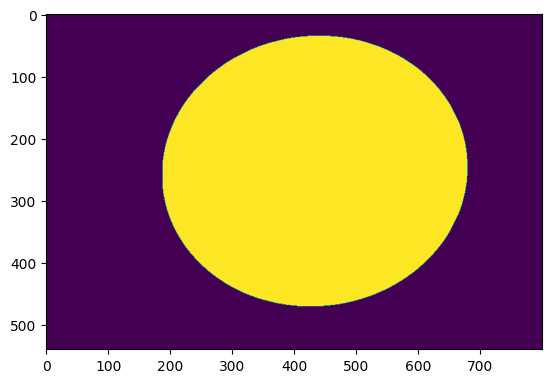

In [ ]:
plt.imshow(img_gray)

In [ ]:
class HeadDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index].replace(".png", "_Annotation.png"))
    #mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
    image = np.array(Image.open(img_path).convert("RGB"))
    #mask = fill_contour_region(mask_path)
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
    # we need to use sigmoid
    mask[mask == 255.0] = 1.0

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask

In [ ]:
from torch.utils.data import DataLoader

### Load Saved Dataset



In [ ]:
save_path = root_path + 'train_data_split/'

In [ ]:
#save_path + 'split_train_size_10.pt'
#save_path + 'split_train_size_30.pt'
save_path + 'split_train_size_50.pt'

'/content/drive/MyDrive/Ultrasound_project/train_data_split/split_train_size_50.pt'

In [ ]:
#train_ds = torch.load(save_path + 'split_train_size_10.pt')
#train_ds = torch.load(save_path + 'split_train_size_30.pt')
train_ds = torch.load(save_path + 'split_train_size_50.pt')

print(f'The lenght of train dataset: {len(train_ds)}')

The lenght of train dataset: 399


### Start DataLoader

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
torch.manual_seed(13204942)

In [ ]:
BATCH_SIZE = 10
NUM_WORKERS = 2
PIN_MEMORY = True

IMAGE_HEIGHT = 512  # 540 originally
IMAGE_WIDTH = 512  # 800 originally

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=25, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

In [ ]:
# split train, validation
full_dataset = HeadDataset(
    image_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=train_transform,
    )

In [ ]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_ds = torch.utils.data.random_split(full_dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
ckpt_name = root_path + "Saved_models/my_Unet_baseline_0717_1.pth.tar"
model_name = root_path + "Saved_models/my_Unet_baseline_0717_1.pth"

In [ ]:
train_loader, val_loader = get_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms,
    NUM_WORKERS,
    PIN_MEMORY,
    )

In [ ]:
print(len(train_loader))
print(len(val_loader))

80
20


## Train Model

In [ ]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

In [ ]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 20
LOAD_MODEL = False

In [ ]:
def save_checkpoint(state, filename="/content/drive/MyDrive/Ultrasound_project/Saved_models/my_Unet_baseline.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def save_model(model, filename="/content/drive/MyDrive/Ultrasound_project/Saved_models/my_Unet_baseline.pth"):
    print("=> Saving model")
    torch.save(model, filename)
    print('Model saved!')

In [ ]:
def check_accuracy(loader, model, loss_fn, device="cuda", is_training = True):
    num_correct = 0
    num_pixels = 0
    dice_score = 0.0
    iou = 0.0
    losses = []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)

            prediction = model(x)

            loss = loss_fn(prediction, y.float())
            losses.append(loss.item())

            preds = torch.sigmoid(prediction)
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
                )
            iou += (preds * y).sum() / (
                (preds + y).sum() - (preds * y).sum() + 1e-8
                )

    print(f"Got validation loss: {np.mean(losses):.6f}")
    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.5f}")
    print(f"Dice score: {dice_score / len(loader)*100:.5f}")
    print(f"mIoU: {iou / len(loader)*100:.5f}")

    if is_training:
      model.train()

In [ ]:
def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda", is_training = True):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    if is_training:
      model.train()

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
  loop = tqdm(loader)

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    # forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      loss = loss_fn(predictions, targets)

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss=loss.item())

  return loss.item()

In [ ]:
LOAD_MODEL = True

In [ ]:
def main(train_loader, val_loader):
  model = UNET(in_channels=3, out_channels=1).to(DEVICE)
  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  #if LOAD_MODEL:
  #  load_checkpoint(torch.load(ckpt_name), model)

  scaler = torch.cuda.amp.GradScaler()

  best_loss = 1.0

  for epoch in range(NUM_EPOCHS):
    losses = []
    model.train()
    current_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

    if best_loss > current_loss:
      best_loss = current_loss
      '''
      save_model(model, model_name)
      # save checkpoint
      checkpoint = {
          "state_dict": model.state_dict(),
          "optimizer":optimizer.state_dict(),
         }
      save_checkpoint(checkpoint, ckpt_name)
      '''

    # check accuracy
    check_accuracy(val_loader, model, loss_fn, device=DEVICE)

    # print some examples to a folder
    #save_predictions_as_imgs(val_loader, model, folder="saved_images/", device=DEVICE)

    losses.append(current_loss)
    print(f"Got training loss: {np.mean(losses):.6f}")

  #save_model(model, model_name)
  # save checkpoint
  checkpoint = {
      "state_dict": model.state_dict(),
      "optimizer":optimizer.state_dict(),
      }
  #save_checkpoint(checkpoint, ckpt_name)
  return model

In [ ]:
model = main(train_loader, val_loader)

100%|██████████| 80/80 [04:23<00:00,  3.29s/it, loss=0.319]


Got validation loss: 0.339774
Got 47113207/52428800 with acc 89.861
Dice score: 0.8435912132263184
mIoU: 0.7325077056884766
Got training loss: 0.319059


100%|██████████| 80/80 [01:22<00:00,  1.03s/it, loss=0.242]


Got validation loss: 0.234147
Got 48835484/52428800 with acc 93.146
Dice score: 0.8758614659309387
mIoU: 0.7820249795913696
Got training loss: 0.241716


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.213]


Got validation loss: 0.215198
Got 49266121/52428800 with acc 93.968
Dice score: 0.9065643548965454
mIoU: 0.8309136629104614
Got training loss: 0.212839


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.141]


Got validation loss: 0.167400
Got 50058051/52428800 with acc 95.478
Dice score: 0.9277817010879517
mIoU: 0.8665854334831238
Got training loss: 0.140949


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.158]


Got validation loss: 0.141793
Got 50521773/52428800 with acc 96.363
Dice score: 0.9378096461296082
mIoU: 0.8843365907669067
Got training loss: 0.158242


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.113]


Got validation loss: 0.126988
Got 50562462/52428800 with acc 96.440
Dice score: 0.9406114816665649
mIoU: 0.8887491226196289
Got training loss: 0.112992


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.103]


Got validation loss: 0.112938
Got 50907762/52428800 with acc 97.099
Dice score: 0.9519409537315369
mIoU: 0.9091166853904724
Got training loss: 0.102504


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.156]


Got validation loss: 0.124796
Got 50435982/52428800 with acc 96.199
Dice score: 0.9389092326164246
mIoU: 0.8862825632095337
Got training loss: 0.156333


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.105]


Got validation loss: 0.103415
Got 50879325/52428800 with acc 97.045
Dice score: 0.9514304995536804
mIoU: 0.9082052111625671
Got training loss: 0.104805


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.0865]


Got validation loss: 0.103349
Got 50742686/52428800 with acc 96.784
Dice score: 0.9460141062736511
mIoU: 0.8982650637626648
Got training loss: 0.086479


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.0897]


Got validation loss: 0.087186
Got 51052613/52428800 with acc 97.375
Dice score: 0.9565022587776184
mIoU: 0.9171096086502075
Got training loss: 0.089662


100%|██████████| 80/80 [01:22<00:00,  1.03s/it, loss=0.0776]


Got validation loss: 0.095394
Got 50960842/52428800 with acc 97.200
Dice score: 0.9543067216873169
mIoU: 0.9134126901626587
Got training loss: 0.077584


100%|██████████| 80/80 [01:22<00:00,  1.03s/it, loss=0.0846]


Got validation loss: 0.086282
Got 50994103/52428800 with acc 97.264
Dice score: 0.9548881649971008
mIoU: 0.9145461916923523
Got training loss: 0.084571


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.0625]


Got validation loss: 0.084122
Got 51012730/52428800 with acc 97.299
Dice score: 0.9550361633300781
mIoU: 0.9146900177001953
Got training loss: 0.062542


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.0614]


Got validation loss: 0.075669
Got 51120481/52428800 with acc 97.505
Dice score: 0.9586101770401001
mIoU: 0.9209052324295044
Got training loss: 0.061419


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.0636]


Got validation loss: 0.073213
Got 51136219/52428800 with acc 97.535
Dice score: 0.9595085978507996
mIoU: 0.922654926776886
Got training loss: 0.063637


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.062]


Got validation loss: 0.070423
Got 51167059/52428800 with acc 97.593
Dice score: 0.9602022171020508
mIoU: 0.9240165948867798
Got training loss: 0.062010


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.074]


Got validation loss: 0.076541
Got 50987421/52428800 with acc 97.251
Dice score: 0.9533544778823853
mIoU: 0.9112057089805603
Got training loss: 0.073955


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.0541]


Got validation loss: 0.066877
Got 51241374/52428800 with acc 97.735
Dice score: 0.9624235033988953
mIoU: 0.9279679656028748
Got training loss: 0.054147


100%|██████████| 80/80 [01:21<00:00,  1.02s/it, loss=0.063]


Got validation loss: 0.066077
Got 51220724/52428800 with acc 97.696
Dice score: 0.9615499377250671
mIoU: 0.9263928532600403
Got training loss: 0.062969


In [ ]:
# save checkpoint
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
checkpoint = {
    "state_dict": model.state_dict(),
    "optimizer":optimizer.state_dict(),
    }
save_checkpoint(checkpoint, ckpt_name)

In [ ]:
model_name

'/content/drive/MyDrive/Ultrasound_project/Saved_models/my_Unet_baseline_0717_1.pth'

In [ ]:
save_model(model, model_name)

=> Saving model
Model saved!


## Test the Baseline Model

Two datasets:
* HC18: 30 ultrasound images
* FETAL_PLANES_ZENODO: 30 ultrasound images

In [ ]:
root_path

'/content/drive/MyDrive/Ultrasound_project/'

In [ ]:
# Spanish/spanishcerebellum_test/images/
# Spanish/spanishthalamic_test/images/
# Spanish/spanishventricular_test/images/

# African/Algeria/images/
# African/Malawi/images/
# African/Egypt/images/

# HC18_UNet_orig/val_images/
# HC18_UNet_orig/val_masks/

TEST_IMG_DIR = root_path + "Spanish/spanishventricular_test/images/"
TEST_MASK_DIR = root_path + "Spanish/spanishventricular_test/masks/"

In [ ]:
test_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

In [ ]:
test_ds = HeadDataset(
    image_dir=TEST_IMG_DIR,
    mask_dir=TEST_MASK_DIR,
    transform=test_transforms,
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
print(TEST_IMG_DIR)
print(len(test_ds))

/content/drive/MyDrive/Ultrasound_project/Spanish/spanishventricular_test/images/
100


In [ ]:
LOAD_MODEL = True

In [ ]:
DEVICE

'cuda'

In [ ]:
if LOAD_MODEL:
  model = UNET(in_channels=3, out_channels=1)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
len(test_ds)

25

In [ ]:
#my_Unet_baseline_0712.pth.tar
#my_Unet_baseline_0717.pth.tar
#my_Unet_baseline_0717_1.pth.tar
#my_Unet_baseline_0717_2.pth.tar

ckpt_name = root_path + 'Saved_models/my_Unet_baseline_0717_1.pth.tar'

### Inference

In [ ]:
model = model.to(DEVICE)

In [ ]:
if LOAD_MODEL:
  load_checkpoint(torch.load(ckpt_name), model)

**HC18**

In [ ]:
# check accuracy
check_accuracy(test_loader, model, loss_fn, device=DEVICE, is_training=False)

=> Loading checkpoint
Got validation loss: 0.066077
Got 51220724/52428800 with acc 97.69577
Dice score: 96.15499
mIoU: 92.63928


**Spanish / African**

In [ ]:
# check accuracy
check_accuracy(test_loader, model, loss_fn, device=DEVICE, is_training=False)

Got validation loss: 0.067610
Got 25604054/26214400 with acc 97.67171
Dice score: 96.46894
mIoU: 93.18408


## Result visualization

In [ ]:
test_dataloader = test_loader

In [ ]:
rand_idx = [2,5,8,10,12,14,16,18]

In [ ]:
#rand_idx = random.sample(range(30), k=5) # select your indices here as a list
#subset = torch.utils.data.Subset(test_fpz_ds, rand_idx)
subset = torch.utils.data.Subset(test_ds, rand_idx)
testloader_subset = DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)

Dice Score is 98.866


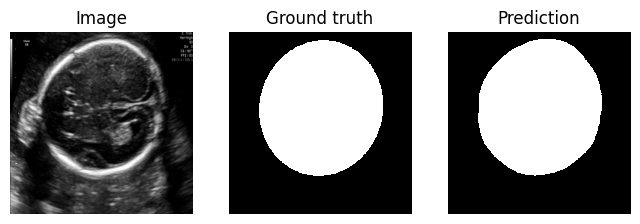

Dice Score is 97.633


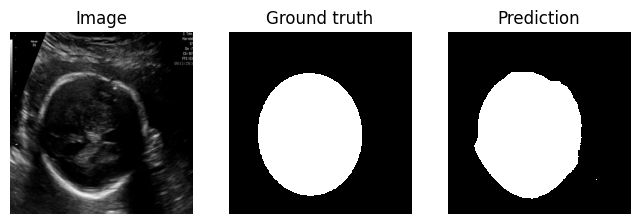

Dice Score is 97.503


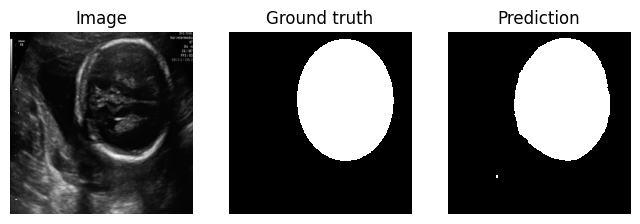

Dice Score is 89.362


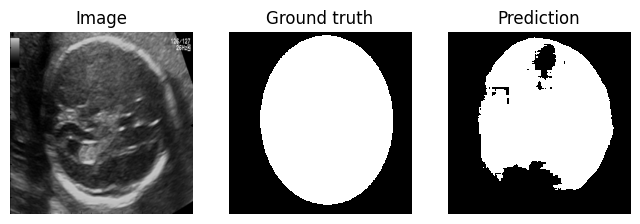

Dice Score is 98.337


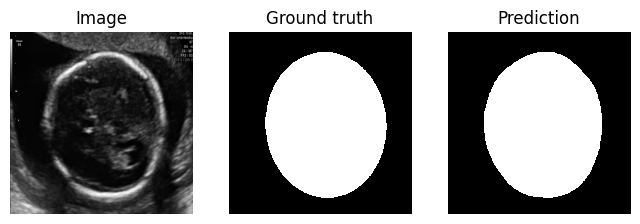

Dice Score is 97.889


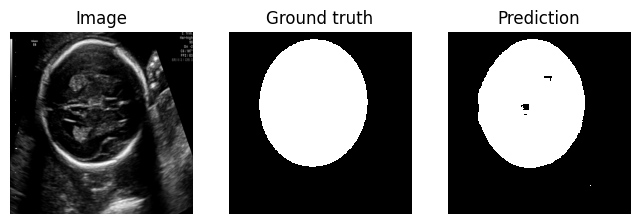

Dice Score is 95.814


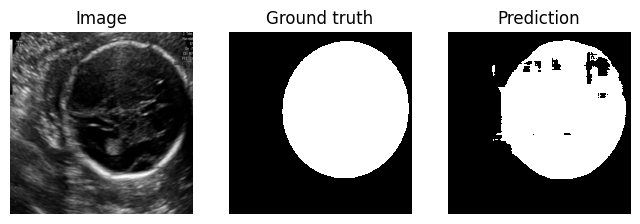

Dice Score is 97.734


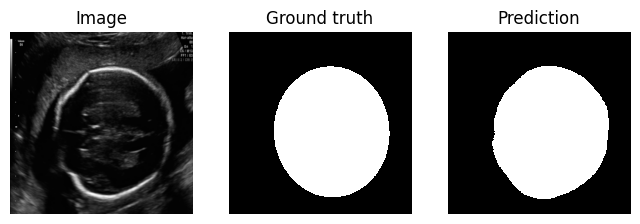

In [ ]:
with torch.no_grad():
  for x, y in testloader_subset:
    image = x.to(DEVICE)
    gt_mask = y.to(DEVICE).unsqueeze(1)
    preds = model(image)
    preds = preds[0]
    preds = (preds > 0.5).float()

    dice_score = (2 * (preds * gt_mask).sum()) / (
        (preds + gt_mask).sum() + 1e-8
        )

    print(f"Dice Score is {dice_score*100:.3f}")

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 3, 1)
    x = x.flatten(0, 1)
    plt.imshow(x.permute(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(1-y.numpy().squeeze(),cmap='Greys',interpolation='nearest') # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(1-preds.cpu().data.numpy().squeeze(),cmap='Greys',interpolation='nearest') # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()